https://github.com/TheShadow29/FAI-notes/blob/master/notebooks/Using-Pretrained-Pytorch-Models.ipynb

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
PATH = '/root/data/sar_cars/'

label_csv = f'{PATH}labels_balanced.csv'
n_classes = len(pd.read_csv(label_csv).car.unique())

n_samples = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n_samples)

In [3]:
tfms_model = resnet50

def get_data(sz,bs):    
    tfms = tfms_from_model(tfms_model, sz)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, bs=bs)

data64 = get_data(64,32)
data160 = get_data(160,16)

In [4]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [5]:
# select and load cadene model with imagenet weights (and classes), print last two layers
model_name = 'se_resnet50'
model_cadene = pretrainedmodels.__dict__[model_name](num_classes=1000,pretrained='imagenet')
list(children(model_cadene))[-2:]

[AvgPool2d(kernel_size=7, stride=1, padding=0, ceil_mode=False, count_include_pad=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

Must modify last few layers of the model. For Fastai models, `ConvLearner.pretrained()` changes the `AvgPool2d` to `AdaptiveConcatPool2d`, Flattens it, adds Linear layers with batch norms and ReLU, adds dropout, and finally puts a LogSoftmax layer.

Adaptive pooling layers used to allow model to use any image size. It specifies output size rather than kernel size.

In [6]:
# Basic: create basic custom head,  add to model, load into ConvLearner
for data in [data64, data160]:

    custom_head = nn.Sequential(AdaptiveConcatPool2d(), Flatten())
    cadene_model = nn.Sequential(*list(children(model_cadene))[:-2], custom_head)
    learn_tmp = ConvLearner.from_model_data(cadene_model, data)
    # Do all this first time just to check output size (and consistency across data size):
    print(learn_tmp.models.model(V(next(iter(data.trn_dl))[0])))

Variable containing:
  0.0000   0.0000   0.4647  ...    0.0000   0.1459   0.0007
  0.0364   0.0000   0.9534  ...    0.0000   0.0038   0.0000
  0.0000   0.0000   3.7666  ...    0.0000   0.0000   0.8244
           ...               ⋱              ...            
  0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0618
  0.0000   0.0000   0.9601  ...    0.0143   0.2130   0.3754
  1.8363   4.8294   0.0000  ...    0.0000   1.0548   3.9862
[torch.cuda.FloatTensor of size 32x4096 (GPU 0)]

Variable containing:
  1.1202   1.0428   1.9617  ...    0.5303   0.2443   0.4317
  4.4056   0.0000   1.0109  ...    0.2052   0.0000   0.7821
  1.3392   0.0000   0.0000  ...    0.0213   1.4398   0.4620
           ...               ⋱              ...            
  1.1088   0.0000   0.0000  ...    0.6518   0.0714   0.1992
  0.4545   4.9761   1.4528  ...    0.1872   0.7669   0.2571
  2.2814   1.1381   2.4471  ...    0.0132   0.1558   0.9335
[torch.cuda.FloatTensor of size 16x4096 (GPU 0)]



In [7]:
output_size = 4096

# create more detailed custom head, add to model, load into ConvLearner
custom_head = nn.Sequential(AdaptiveConcatPool2d(), Flatten(), nn.BatchNorm1d(output_size),
                            nn.Linear(in_features=output_size, out_features=512), nn.ReLU(),
                            nn.BatchNorm1d(512), nn.Linear(in_features=512, out_features=n_classes),
                            nn.LogSoftmax())
cadene_model = nn.Sequential(*list(children(model_cadene))[:-2], custom_head)
learn = ConvLearner.from_model_data(cadene_model, data)

 82%|████████▏ | 1714/2078 [03:08<00:40,  9.08it/s, loss=6.91]

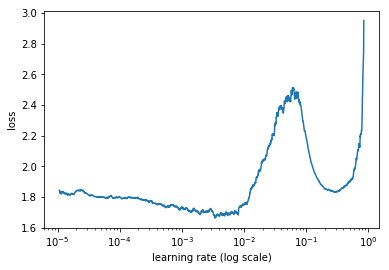

In [8]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(1e-1, 5, cycle_len=1, cycle_mult=1, best_save_name='best_mod', metrics=[accuracy])
learn.sched.plot_loss()

epoch      trn_loss   val_loss   accuracy                     
    0      1.770632   40.927366  0.19521   
  1%|          | 18/2078 [00:02<04:14,  8.08it/s, loss=1.78]